In [81]:
# Import libraries
import requests
import numpy as np
import pandas as pd
from datetime import datetime, date, time
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

In [52]:
# reads in bitcoin data from a downloaded csv file
bitcoin = pd.read_csv("C:\\Qilin\\Python\\CryptoReturnsModelling\\btc-usd-max.csv")

# modifies indexes to get rid of timezone format and reindex to given values in csv
bitcoin['snapped_at'] = pd.to_datetime(bitcoin.snapped_at).dt.tz_localize(None)
bitcoin.index = bitcoin['snapped_at']

# resamples data to last of the month
bitcoin = bitcoin.resample('M').last()

# deletes original index reference column and creates returns column
del bitcoin['snapped_at']
bitcoin['Returns'] = bitcoin['price'].pct_change().cumsum().fillna(0).multiply(100)

# display data
bitcoin.head()

,price,market_cap,total_volume,Returns
snapped_at,,,,
2013-04-30,135.3000,1.501657e+09,0.0,0.000000
2013-05-31,127.9800,1.436387e+09,0.0,-5.410200
2013-06-30,95.3886,1.082694e+09,0.0,-30.876210
2013-07-31,110.3400,1.267183e+09,0.0,-15.202010
2013-08-31,137.7600,1.602407e+09,0.0,9.648452


In [67]:
# full coin list
coin_list = ['BTC', 'ETH', 'XRP', 'BCH', 'ADA', 
             'XLM', 'NEO', 'LTC', 'EOS', 'XEM', 'IOTA', 
             'DASH', 'XMR', 'TRX', 'ICX', 'ETC', 'QTUM', 
             'BTG', 'LSK', 'USDT', 'OMG', 'ZEC', 'SC', 'ZRX', 
             'REP', 'WAVES', 'MKR', 'DCR', 'BAT', 'LRC', 
             'KNC', 'BNT', 'LINK', 'CVC', 'RLC', 'ENJ', 'STORJ', 
             'ANT', 'SNGLS', 'MANA', 'MLN', 'DNT', 'AMP', 'NMR', 
             'DOT', 'DAI', 'UNI', 'ATOM', 'GRT', 'LUNA', 'XTZ', 
             'FIL', 'NANO', 'WBTC', 'BSV', 'DOGE', 'USDC', 'OXT', 
             'ALGO', 'BAND', 'BTT', 'FET', 'KAVA', 'PAX', 'PAXG', 
             'REN', 'AAVE', 'YFI', 'NU', 'MATIC', 'ICP', 'SOL', 'SUSHI', 
             'UMA', 'SNX', 'CRV', 'COMP', 'CELO', 'KSM', 'NKN', 'SHIB', 
             'SKL', 'SAND', 'UST', 'AVAX', 'IOTX', 'AXS', 'XYO', 
             'ANKR', 'CHZ', 'LPT', 'COTI', 'KEEP']

# Shorter CoinDesk 20
coindesk_20 = ['BTC', 'ETH', 'XRP', 'ADA', 'USDT', 'DOGE', 
               'XLM', 'DOT', 'UNI', 'LINK', 'USDC', 'BCH', 
               'LTC', 'GRT', 'ETC', 'FIL', 'AAVE', 'ALGO', 'EOS']

In [83]:
# Setting dataframes
raw_df = pd.DataFrame()
for coin in coin_list:
    # individual coin dataframe
    df = pd.DataFrame(index=[0])
    
    # Define start and end times
    enddate = datetime.combine(date.today(), time())
    startdate = datetime(2013, 1, 1, 0, 0)
    
    # get url based on start and end
    url = 'https://production.api.coindesk.com/v2/price/values/' + coin + '?start_date=' + \
            startdate.strftime("%Y-%m-%dT%H:%M") + \
            '&end_date=' + enddate.strftime("%Y-%m-%dT%H:%M") + '&ohlc=false'
    
    # request json data
    temp_data_json = requests.get(url)
    temp_data = temp_data_json.json()
    df = pd.DataFrame(temp_data['data']['entries'])
    df.columns = ['Timestamp', 'Close']
    
    # redo timestamp labelling
    df = df.drop(['Timestamp'], axis=1)
    # loops values by end date
    df['Datetime'] = [enddate - relativedelta(days=len(df)-i) for i in range(0, len(df))]
    df['Datetime'] = pd.to_datetime(df.Datetime).dt.tz_localize(None)
    df.index = pd.to_datetime(df['Datetime'])
    
    # resamples the data monthly and then indexes to match bitcoin index
    df = df.resample('M').last()
    
    # sets symbol column to coin name and adds df to overall
    df['Symbol'] = coin
    raw_df = raw_df.append(df)

# creates pivot table with new columns of symbol and values of close
raw_df = raw_df[['Datetime', 'Symbol', 'Close']]
print(raw_df)
crypto_df = raw_df.pivot(index='Datetime', columns='Symbol', values='Close')

             Datetime Symbol        Close
Datetime                                 
2013-10-31 2013-10-31    BTC   196.024990
2013-11-30 2013-11-30    BTC  1154.925930
2013-12-31 2013-12-31    BTC   744.172490
2014-01-31 2014-01-31    BTC   841.489140
2014-02-28 2014-02-28    BTC   567.292500
...               ...    ...          ...
2022-03-31 2022-03-28   COTI     0.280893
2021-12-31 2021-12-31   KEEP     0.732407
2022-01-31 2022-01-31   KEEP     0.447327
2022-02-28 2022-02-28   KEEP     0.865608
2022-03-31 2022-03-28   KEEP     0.640055

[2007 rows x 3 columns]


In [84]:
# writes output to csv
out_path = r"C:\Qilin\Python\CryptoReturnsModelling\out\CoinDesk20.csv"
crypto_df.to_csv(out_path)

In [85]:
# gets data from saved excel
in_path = r"C:\Qilin\Python\CryptoReturnsModelling\out\CoinDesk20.csv"
df = pd.read_csv(in_path)
df.index = pd.to_datetime(df['Datetime'])
df = df.drop(['Datetime'], axis=1)

# creates coin-returns list to average all
coin_returns = []
for coin in df:
    name = coin + '_returns'
    df[name] = df[coin].pct_change().multiply(100).cumsum()
    
    # excludes stable coins
    if df[name].iloc[-1] < 10:
        continue
    coin_returns.append(name)
df['avgReturns'] = df[coin_returns].mean(axis=1)
print(df)

                  AAVE       ADA      ALGO       AMP      ANKR        ANT  \
Datetime                                                                    
2013-10-31         NaN       NaN       NaN       NaN       NaN        NaN   
2013-11-30         NaN       NaN       NaN       NaN       NaN        NaN   
2013-12-31         NaN       NaN       NaN       NaN       NaN        NaN   
2014-01-31         NaN       NaN       NaN       NaN       NaN        NaN   
2014-02-28         NaN       NaN       NaN       NaN       NaN        NaN   
...                ...       ...       ...       ...       ...        ...   
2021-11-30  251.024775  1.541272  1.924840  0.059039       NaN   5.387873   
2021-12-31  261.354628  1.370315  1.738494  0.049567  0.102699  13.037144   
2022-01-31  163.158029  1.073382  0.963452  0.030072  0.077929   7.500508   
2022-02-28  142.821576  0.966431  0.851108  0.028694  0.075950   5.677859   
2022-03-28  213.962188  1.181513  0.909137  0.026849  0.086165   5.331700   

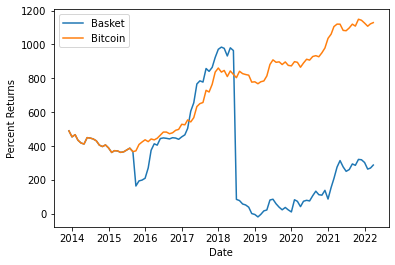

In [86]:
# plots basket returns in blue
plt.plot(df['avgReturns'], label="Basket")

# plots bitcoin returns in orange
plt.plot(df['BTC_returns'], label="Bitcoin")

# relabels axes and creates legend
plt.xlabel("Date")
plt.ylabel("Percent Returns")
plt.legend()

# save figure
outgraph = r"C:\Qilin\Python\CryptoReturnsModelling\out\Returns.png"
plt.savefig(outgraph)

plt.show()

In [93]:
# now we rebalance with top 5 performers each month
def portfolio(data, numStocks):
    df = data.copy()
    
    avg_returns = []
    top = []
    # loops through each row
    for i in range(len(df)):
        # for the first couple rows there will be less than 5 coins
        # in that case we take the mean of those coins performances
        if df.iloc[i,:].count() < 5:
            avg_returns.append(df.iloc[i,:].mean())
        
        # otherwise we take the mean of the top 5 from the previous month
        else: 
            avg_returns.append(df[top].iloc[i,:].mean())
        
        # create new top 5 for next month
        top = df.iloc[i,:].sort_values(ascending=False)[:numStocks].index.values.tolist()
        
    returns_df = pd.DataFrame(np.array(avg_returns), columns=['monthly_returns'], index=df.index)
    return returns_df

In [94]:
# adds in CAGR column to df
def CAGR(data):
    for coin in data:
        name = coin + '_returns'
        df[name] = data[coin].pct_change().multiply(100)

In [91]:
# gets data from saved excel
in_path = r"C:\Qilin\Python\CryptoReturnsModelling\out\CoinDesk20.csv"
data = pd.read_csv(in_path)
data.index = pd.to_datetime(data['Datetime'])
data = data.drop(['Datetime'], axis=1)

# adds in columns of noncumulative monthly returns
for coin in data:
    name = coin + '_returns'
    df[name] = data[coin].pct_change().multiply(100)

# driver code
topFive = portfolio(data, 5)
topFive['CAGR'] = topFive['monthly_returns'].cumsum()
print(topFive)

[]
['BTC', 'AAVE', 'ADA', 'ALGO', 'AMP']
['BTC', 'AAVE', 'ADA', 'ALGO', 'AMP']
['BTC', 'AAVE', 'ADA', 'ALGO', 'AMP']
['BTC', 'AAVE', 'ADA', 'ALGO', 'AMP']
['BTC', 'AAVE', 'ADA', 'ALGO', 'AMP']
['BTC', 'AAVE', 'ADA', 'ALGO', 'AMP']
['BTC', 'AAVE', 'ADA', 'ALGO', 'AMP']
['BTC', 'AAVE', 'ADA', 'ALGO', 'AMP']
['BTC', 'AAVE', 'ADA', 'ALGO', 'AMP']
['BTC', 'AAVE', 'ADA', 'ALGO', 'AMP']
['BTC', 'AAVE', 'ADA', 'ALGO', 'AMP']
['BTC', 'AAVE', 'ADA', 'ALGO', 'AMP']
['BTC', 'AAVE', 'ADA', 'ALGO', 'AMP']
['BTC', 'AAVE', 'ADA', 'ALGO', 'AMP']
['BTC', 'AAVE', 'ADA', 'ALGO', 'AMP']
['BTC', 'AAVE', 'ADA', 'ALGO', 'AMP']
['BTC', 'AAVE', 'ADA', 'ALGO', 'AMP']
['BTC', 'AAVE', 'ADA', 'ALGO', 'AMP']
['BTC', 'AAVE', 'ADA', 'ALGO', 'AMP']
['BTC', 'AAVE', 'ADA', 'ALGO', 'AMP']
['BTC', 'AAVE', 'ADA', 'ALGO', 'AMP']
['BTC', 'AAVE', 'ADA', 'ALGO', 'AMP']
['BTC', 'ETH', 'AAVE', 'ADA', 'ALGO']
['BTC', 'ETH', 'AAVE', 'ADA', 'ALGO']
['BTC', 'ETH', 'AAVE', 'ADA', 'ALGO']
['BTC', 'ETH', 'AAVE', 'ADA', 'ALGO']
['BTC', '

This looks really suspicious but considering the explosive performance of cryptocurrencies is not out of consideration. It is still a work in progress and will be optimized to be more realistic

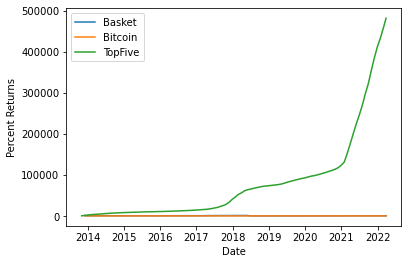

In [92]:
# Comparing rebalanced 5 to bitcoin and previous basket
# plots basket returns in blue
plt.plot(df['avgReturns'], label="Basket")

# plots bitcoin returns in orange
plt.plot(df['BTC_returns'], label="Bitcoin")

# plots rebalanced in green
plt.plot(topFive['CAGR'], label='TopFive')

# relabels axes and creates legend
plt.xlabel("Date")
plt.ylabel("Percent Returns")
plt.legend()

# save figure
outgraph = r"C:\Qilin\Python\CryptoReturnsModelling\out\Returns.png"
plt.savefig(outgraph)

plt.show()